In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('Hitters.csv')
# drop missing
df = df.dropna()
# drop name
df = df.drop('Unnamed: 0', axis = 1)
# set salary as dependent variable
y = df['Salary']
# set predictors excluding categorical predictors
x = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1)
dftest = df.drop(['League', 'Division', 'NewLeague'], axis = 1)

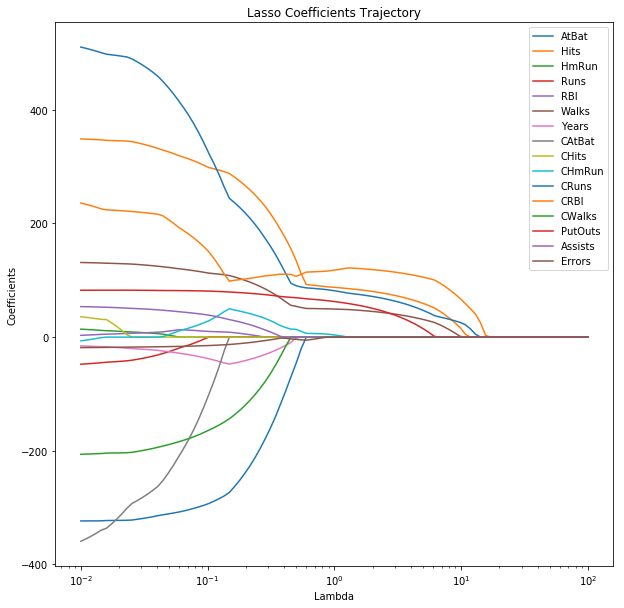

In [7]:
alpha = 10**np.linspace(2,-2,100)
lasso = Lasso(normalize = True,max_iter=1e5)
coefs = []
# standardize x 
xstd = StandardScaler().fit_transform(x)

for a in alpha:
    lasso.set_params(alpha=a)
    lasso.fit(xstd, y)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.plot(alpha, coefs)
plt.title('Lasso Coefficients Trajectory')
ax.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.legend(list(x),loc = 1)

In this plot, we can see that when there are 3 non zero coefficients left, alpha is between 10 and 20

In [15]:
# last three coefficients
def getlastCoef(x,coefs):
    for i in coefs:
        if sum(i != 0) ==3:
            return(x.columns[i != 0])
                
getlastCoef(x,coefs)

Index(['Hits', 'CRuns', 'CRBI'], dtype='object')

The final three predictors that remain in the model are "Hits","CRuns" and "CRBI"

In [11]:
lassocv = LassoCV(cv = 10, normalize = True)
lassocv.fit(scale(x), y)

cvalpha = lassocv.alpha_ 
cvalpha

0.0635481759985745

The optimal value of the regularization penalty is 0.0635

In [12]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=cvalpha)
lasso.fit(scale(x), y)
y_pred = lasso.predict(x)
result = pd.DataFrame()
result['predictor'] = x.columns
result['coef'] = list(lasso.coef_)
result

,predictor,coef
0,AtBat,-306.250203
1,Hits,317.123280
2,HmRun,0.000000
3,Runs,-17.400688
4,RBI,12.827646
5,Walks,119.477368
6,Years,-29.221895
7,CAtBat,-198.704203
8,CHits,0.000000
9,CHmRun,12.836778


After plugging in the regularization penalty, there are 14 predictors left in the model (all predictors except HmRun and CHits.

## Ridge Regression

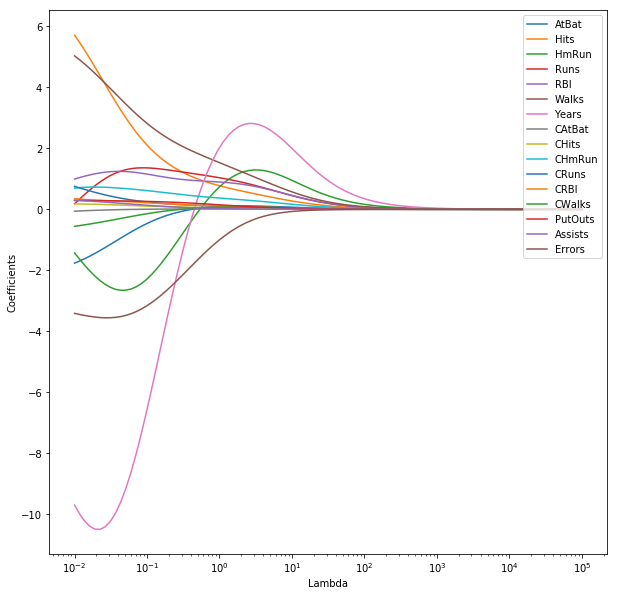

In [56]:
alpha = 10**np.linspace(5,-2,100)
ridge = Ridge(normalize = True)
coef = []

for a in alpha:
    ridge.set_params(alpha = a)
    ridge.fit(x, y)
    coef.append(ridge.coef_)

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.plot(alpha, coef)
ax.set_xscale('log')
plt.title('Ridge Coefficients Trajectory')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.legend(list(x),loc = 1)

In [31]:
ridgecv = RidgeCV(alphas = alpha,cv = 10, normalize = True)
ridgecv.fit(x, y)
ridgecv.alpha_

0.9545484566618337

The optimal value of the regularization penalty is 0.9545

# Part 2 Short Answer

## 2.1 Bias variance tradeoff

Bias is difference between predicted value and its actual value. Variance is measure of sensitivity to small changes in training set. Less flexible models have high bias but low variance and more flexible models have low bias but high variance. Flexible models such as multiple regression trend to have a smaller bias and higher variance and inflexible models such as linear regression trend to have a larger bias and smaller variance. Our goal is to minimize both bias and variance. However, we can't minimize both and there must be a tradeoff between the two. 

## 2.2 What role does regularization play in this tradeoff? 

In both lasso and ridge regression, the alpha is a penalty parameter. A larger alpha means that more restrctions on  coefficients. In this case, bias becomes larger and variance becomes smaller.When $\alpha \rightarrow \infty$, all  coefficients will be 0 (lasso) or close to 0 (ridge). 

## 2.3 Make reference to your findings in number (1) to describe models of high/low bias and variance

The coefficient trajectories show that in both ridge and lasso, when alpha becomes larger, coefficients become smaller and eventually go to zero in lasso and very close to zero in ridge. 
One way to measure bias and variance is to use training and test set. Bias can be measured using MSE in training set and overfitting can be measured by using test MSE.

In [50]:
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=123)
alpha = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100]
lasso = Lasso(max_iter = 10000, normalize = True)
result_train = []
result_test = []
for i in alpha:
    lasso.set_params(alpha=i)
    lasso.fit(x_train, y_train)
    y_pred_train = lasso.predict(x_train)
    result_train.append(mean_squared_error(y_train, y_pred_train))
    y_pred_test = lasso.predict(x_test)
    result_test.append(mean_squared_error(y_test, y_pred_test))
result = pd.DataFrame()
result['Alpha'] = alpha
result['Training MSE'] = result_train
result['Test MSE'] = result_test
result

,Alpha,Training MSE,Test MSE
0,0.05,101989.154285,119616.773094
1,0.10,102481.100599,120107.065035
2,0.20,103392.150244,120716.406741
3,0.50,108944.637267,127573.151719
4,1.00,112382.056782,122287.045054
5,2.00,116615.594381,118170.490746
6,5.00,124088.723272,117339.569546
7,10.00,144108.515099,128599.932155
8,20.00,186918.147396,140874.096036
9,50.00,240041.113473,167029.300438


In [51]:
alpha = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100]
ridge = Ridge(max_iter = 10000, normalize = True)
result_train = []
result_test = []
for i in alpha:
    ridge.set_params(alpha=i)
    ridge.fit(x_train, y_train)
    y_pred_train = ridge.predict(x_train)
    result_train.append(mean_squared_error(y_train, y_pred_train))
    y_pred_test = ridge.predict(x_test)
    result_test.append(mean_squared_error(y_test, y_pred_test))
result = pd.DataFrame()
result['Alpha'] = alpha
result['Training MSE'] = result_train
result['Test MSE'] = result_test
result

,Alpha,Training MSE,Test MSE
0,0.05,106152.569212,120775.897762
1,0.10,108731.670744,119775.876656
2,0.20,112147.916853,117503.983146
3,0.50,117863.125392,113091.733172
4,1.00,123172.082264,109339.366554
5,2.00,130293.171587,106444.888925
6,5.00,146330.900236,108145.549264
7,10.00,165713.941634,116848.351943
8,20.00,188273.943282,130398.122726
9,50.00,213279.942589,147448.906304


In both ridge and lasso regression, as alpha gets larger, training MSE gets larger (bias is increasing). On the other hand, as alpha gets higher, overfitting problem gets smaller (overfitting occurs when testing error is significantly higher than training error). When alpha becomes too large, models become underfit (here all coefficients are zero or close to zero, models become very inflexible). As alpha gets larger, regularization trades off an increase in bias for a decrease in variance. 